<a href="https://colab.research.google.com/github/arnav257/Exoplanets_Krittika/blob/master/Elliptical%20Orbit-%20Limb%20Darkening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from matplotlib.pyplot import style
import seaborn as sns
sns.set()
style.use('seaborn-talk')

### System Parameters-

In [ ]:
G = 6.673e-11
R_s = 696340000 #parameter
M_s = 1.989e30 #parameter
a = 778000000000 #parameter
R_p = 69911000 #parameter

e = 0.7

P = 2*np.pi*np.sqrt(a**3/(G*M_s)) #Kepler's Third Law

### Orientation Parameters-

In [ ]:
i = 0.9995*np.pi/2 #parameter- t_T and t_F exist only for i close to pi/2
Omega = np.pi/3
omega = np.pi/100

In [ ]:
def nuoft(t): #true anomaly as a function of time
    T = 0
    M = 2*np.pi*(t-T)/P
   
    #Numerically solving M = E-e*sinE
    E_n1 = M
    E_n0 = 0
    
    while abs(E_n1-E_n0)>0.1:
        temp = M + e*np.sin(E_n1)
        E_n0 = E_n1
        E_n1 = temp
    
    E = E_n1
    
    nu = np.arccos((np.cos(E)-e)/(1-e*np.cos(E)))
    if E>np.pi: #Accounting for the limited range of arccos
        nu = 2*np.pi - nu
        
    return nu

In [ ]:
def unitVector(nu):
    n_x = -np.cos(i)*np.cos(Omega)*np.sin(omega+nu)-np.sin(Omega)*np.cos(omega+nu)
    n_y = np.cos(Omega)*np.cos(omega+nu)-np.cos(i)*np.sin(Omega)*np.sin(omega+nu)
    n_z = np.sin(i)*np.sin(omega+nu)
    return np.array([n_x,n_y,n_z])


def getposition(nu):
  position = np.array([r*unitVector(nu)[0],r*unitVector(nu)[1],r*unitVector(nu)[2]])
  return position

In [ ]:
def ld_1param(theta, u = 0.5):
    mu = np.cos(theta)
    return 1 - u*(1-mu)


def ld_2param(theta, u1 = 0.25, u2 = 0.4):
    mu = np.cos(theta)
    return 1 - u1 * (1 - mu) - u2 * (1 - mu)**2


def ld_3param(theta, u1 = 0.25, u2 = 0.15, u3 = 0.10):
    mu = np.cos(theta)
    return 1 - u1*(1 - mu) - u2*(1 - mu**1.5) - u3*(1 - mu**2)


def ld_4param(theta, u1 = 0.30, u2 = 0.10, u3 = 0.07, u4 = 0.03):
    mu = np.cos(theta)
    return 1 - u1*(1 - mu**0.5) - u2*(1 - mu) - u3*(1 - mu**1.5) - u4*(1 - mu**2)


def ld_factor(s,R_s,p,R_p,param=2,u = 0.5,u1 = 0.30, u2 = 0.10, u3 = 0.07, u4 = 0.03):
    d = np.linalg.norm(p-s)
    if (d<=R_s+R_p):
      if (d >= R_s-R_p):
        theta = np.pi/2
      elif (d<R_s-R_p):
        theta = np.arcsin(d/R_s)
      if param==1:
          return ld_1param(theta,u = 0.5)
      elif param==2:
          return ld_2param(theta, u1 = 0.25, u2 = 0.4)
      elif param==3:
          return ld_3param(theta,u1 = 0.25, u2 = 0.15, u3 = 0.10)
      elif param==4:
          return ld_4param(theta,u1 = 0.30, u2 = 0.10, u3 = 0.07, u4 = 0.03)
    else:
      return 0

In [ ]:
t = np.linspace(0,P,500000)
nu = np.array([nuoft(time) for time in t])

r = a*(1-e**2)/(1+e*np.cos(nu))
position = getposition(nu)

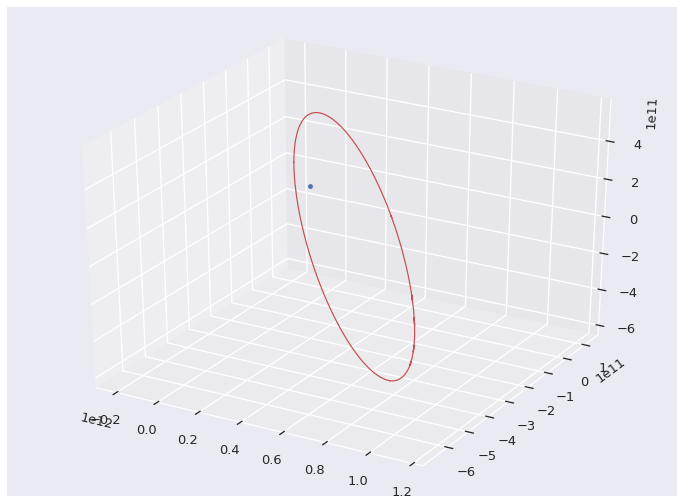

In [ ]:
fig = plt.figure(figsize=(12,9))
ax = fig.gca(projection='3d')
ax._axis3don = True

ax.plot(*position, "-r", linewidth = 1.2)
ax.scatter(0,0,0)


plt.show()

## Projection:


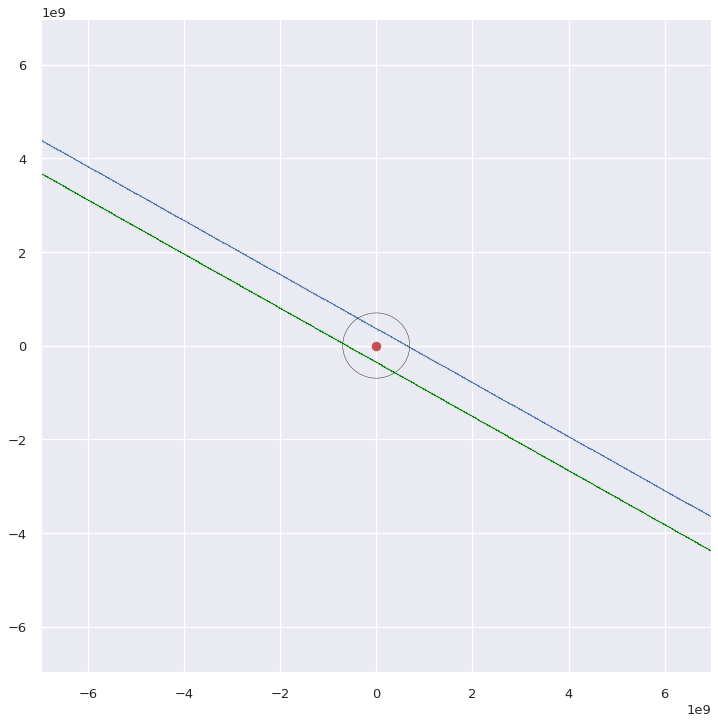

In [ ]:
fig = plt.figure(figsize=(12,12))
plt.scatter(position[0][np.where(position[2]<0)],position[1][np.where(position[2]<0)],c='b',s=0.75)
plt.scatter(position[0][np.where(position[2]>0)],position[1][np.where(position[2]>0)],c='green',s=0.75)

ax = plt.gcf().gca()

star=plt.Circle([0,0],R_s,color='black',fill=False)
ax.add_artist(star)
plt.scatter(0,0,c='r')


plt.ylim(-10*R_s,10*R_s)
plt.xlim(-10*R_s,10*R_s)
plt.show()

## Intersectional Area:

In [ ]:
def intersection_area(s, R, p, r):
    """Return the area of intersection of two circles."""
    d = np.linalg.norm(p-s)
    if d <= abs(R-r):
        # One circle is entirely enclosed in the other.
        return np.pi * min(R, r)**2
    if d >= r + R:
        # The circles don't overlap at all.
        return 0

    r2, R2, d2 = r**2, R**2, d**2
    alpha = np.arccos((d2 + r2 - R2) / (2*d*r))
    beta = np.arccos((d2 + R2 - r2) / (2*d*R))
    return ( r2 * alpha + R2 * beta -
             0.5 * (r2 * np.sin(2*alpha) + R2 * np.sin(2*beta)))

In [ ]:
def getLDFactors(coord_s,R_s,coord_p,R_p,param=3):
  return np.array([ld_factor(coord_s,R_s,p,R_p,param) for p in coord_p])

def getLDFlux(intersect_area, coord_s,R_s,coord_p,R_p,param=3):
  return intersect_area*getLDFactors(coord_s,R_s,coord_p,R_p,param)

<Figure size 864x864 with 0 Axes>

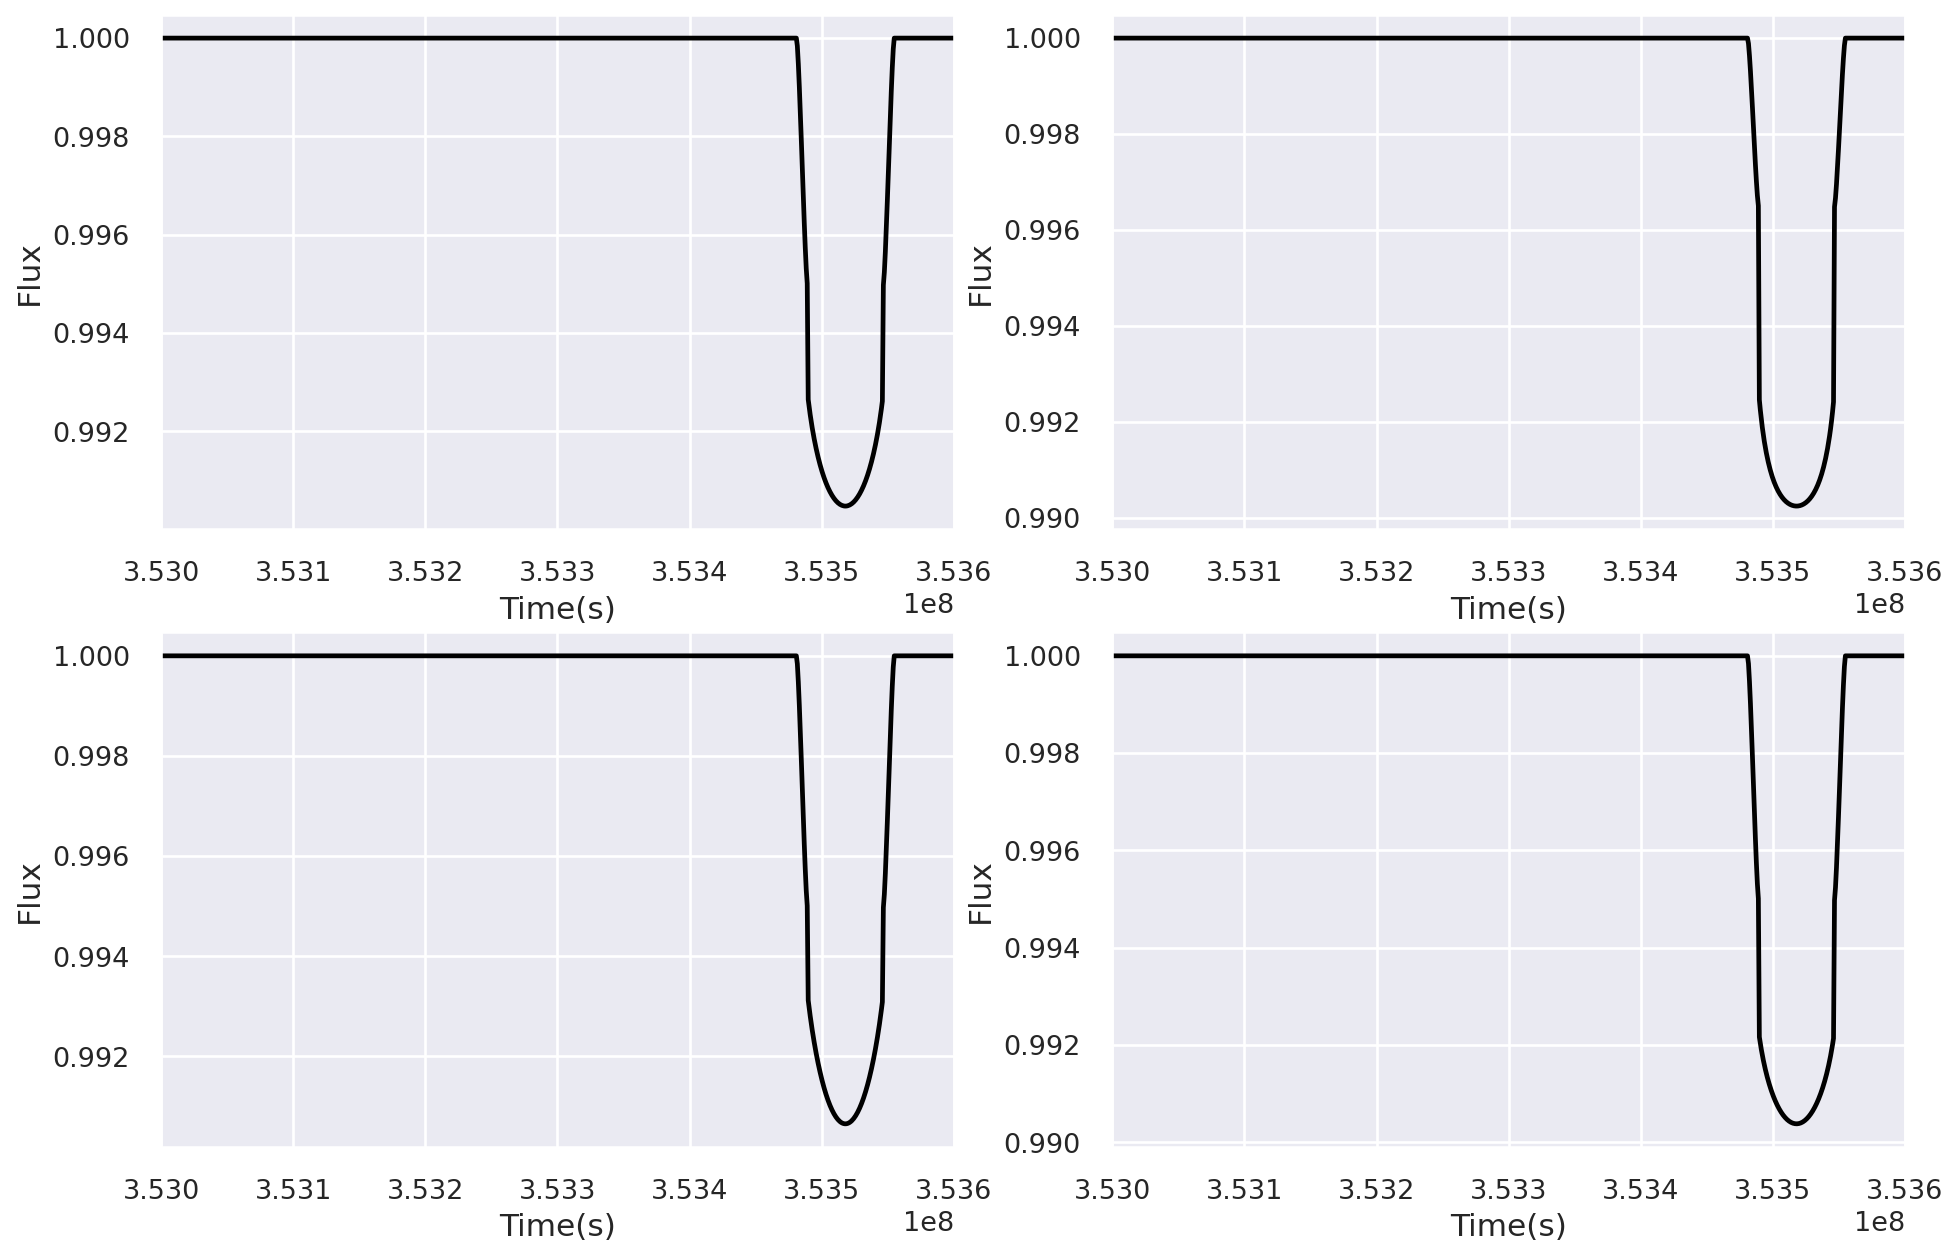

In [ ]:
plt.figure(figsize=(12,12))
coord_p = np.column_stack((position[0],position[1]))
coord_s = np.array([0,0])

posdata = (coord_s,R_s,coord_p,R_p)

area = np.array([intersection_area(coord_s,R_s,p,R_p) for p in coord_p]) 

limbfactor = getLDFactors(*posdata,param=3)

for i,x in enumerate(position[2]):
  if x>0:
    area[i]=0


def formatter(ax):
    ax.set_ylabel('Flux',fontsize='15',fontweight='roman')
    ax.set_xlabel('Time(s)',fontsize='15',fontweight='roman')
    ax.ticklabel_format(style='scientific',axis='x',scilimits=(0,0))
    ax.set_xlim(3.53e8,3.536e8)



finalfig = plt.figure(figsize=(15,10),dpi=150)

param1 = plt.subplot(221)
formatter(param1)
param1.plot(t,1-getLDFlux(area, *posdata,1)/(np.pi*R_s**2),c='black')

param2 = plt.subplot(222)
formatter(param2)
param2.plot(t,1-getLDFlux(area, *posdata,2)/(np.pi*R_s**2),c='black')

param3 = plt.subplot(223)
formatter(param3)
param3.plot(t,1-getLDFlux(area, *posdata,3)/(np.pi*R_s**2),c='black')

param4 = plt.subplot(224)
formatter(param4)
param4.plot(t,1-getLDFlux(area, *posdata,4)/(np.pi*R_s**2),c='black')

plt.show()